# Data Science Salaries

## 1. Data Analysis and Preprocessing

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Set style for better visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")

path = "data\\ds_salaries.csv"

# Load the dataset
df = pd.read_csv(path)

def prepare_data(df):
    # Create copy to avoid modifying original data
    data = df.copy()
    
    # Convert salary_in_usd to thousands for better readability
    data['salary_in_usd'] = data['salary_in_usd'] / 1000
    
    # Label encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
    
    for col in categorical_cols:
        data[col + '_encoded'] = le.fit_transform(data[col])
    
    return data

In [2]:
# Prepare data
processed_data = prepare_data(df)

## 2. Visualizations

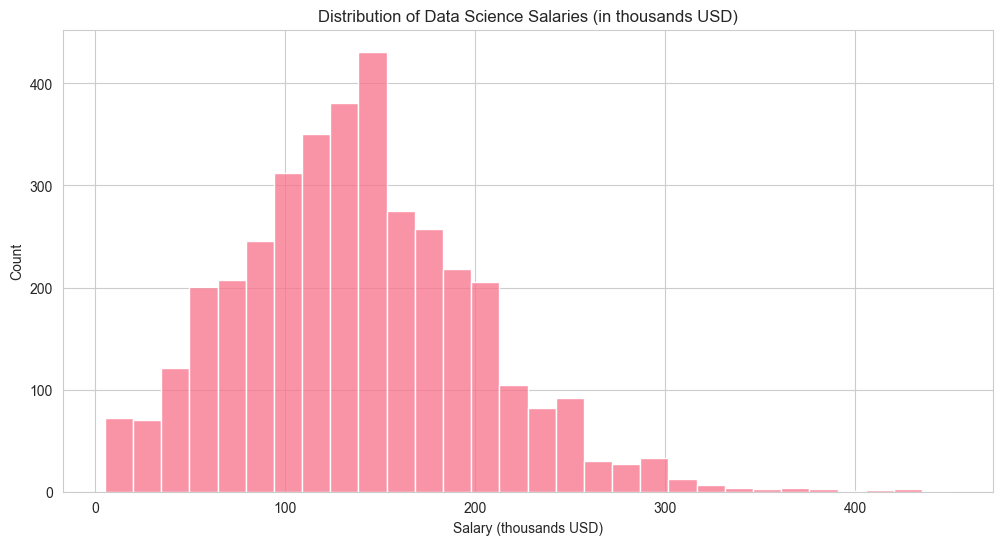

In [3]:
# 2.1 Salary Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=processed_data, x='salary_in_usd', bins=30)
plt.title('Distribution of Data Science Salaries (in thousands USD)')
plt.xlabel('Salary (thousands USD)')
plt.ylabel('Count')
plt.show()

This histogram reveals the overall salary distribution, helping us understand the central tendency, spread, and potential outliers in data science compensation. It's crucial for identifying salary ranges and potential skewness in the dataset.

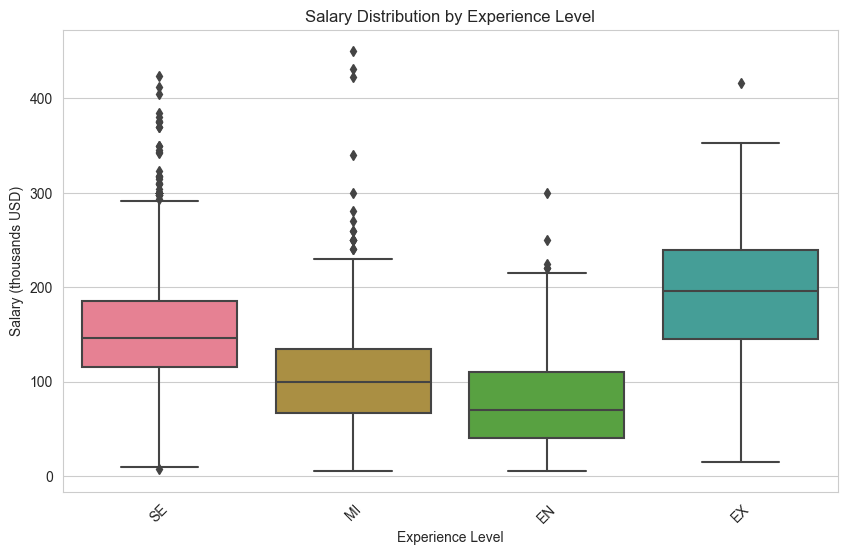

In [4]:
# 2.2 Salary by Experience Level
plt.figure(figsize=(10, 6))
sns.boxplot(data=processed_data, x='experience_level', y='salary_in_usd')
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (thousands USD)')
plt.xticks(rotation=45)
plt.show()

The box plot compares salary distributions across different experience levels, revealing how compensation progresses with career advancement. This visualization helps identify salary progression, median values, and outliers for each experience tier.

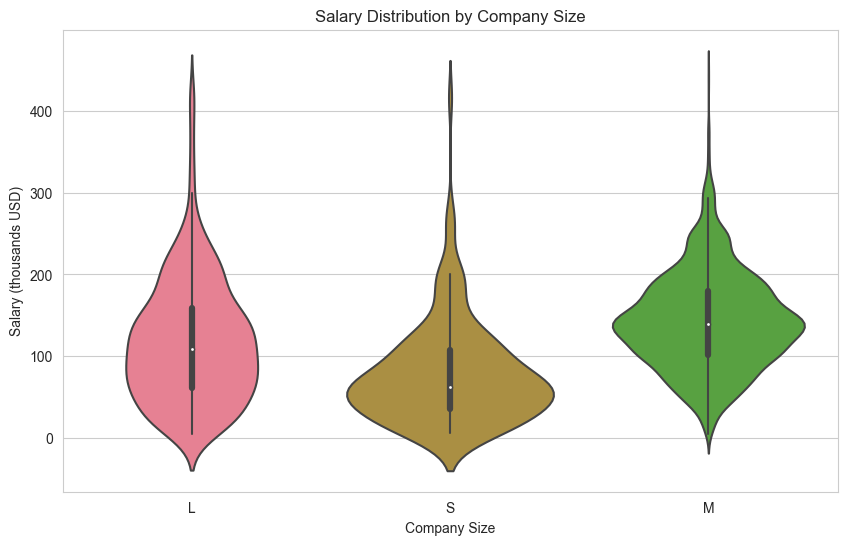

In [5]:
# 2.3 Salary by Company Size
plt.figure(figsize=(10, 6))
sns.violinplot(data=processed_data, x='company_size', y='salary_in_usd')
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary (thousands USD)')
plt.show()

The violin plot shows the nuanced salary distribution across different company sizes. Unlike a simple box plot, it reveals the full probability density, highlighting how company size impacts salary structure and variability.

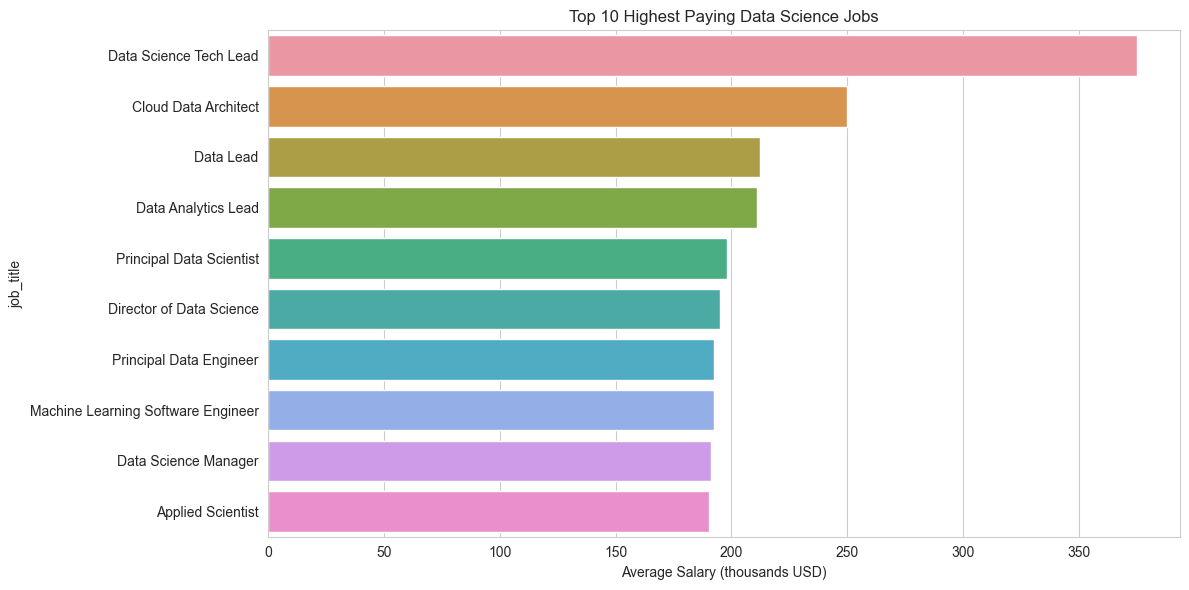

In [6]:
# 2.4 Top 10 Paying Job Titles
plt.figure(figsize=(12, 6))
job_salary = processed_data.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=job_salary.values, y=job_salary.index)
plt.title('Top 10 Highest Paying Data Science Jobs')
plt.xlabel('Average Salary (thousands USD)')
plt.tight_layout()
plt.show()

This bar chart identifies the highest-paying job titles in data science, providing insight into career paths and potential salary expectations. It helps understand which specific roles command the highest compensation in the field.

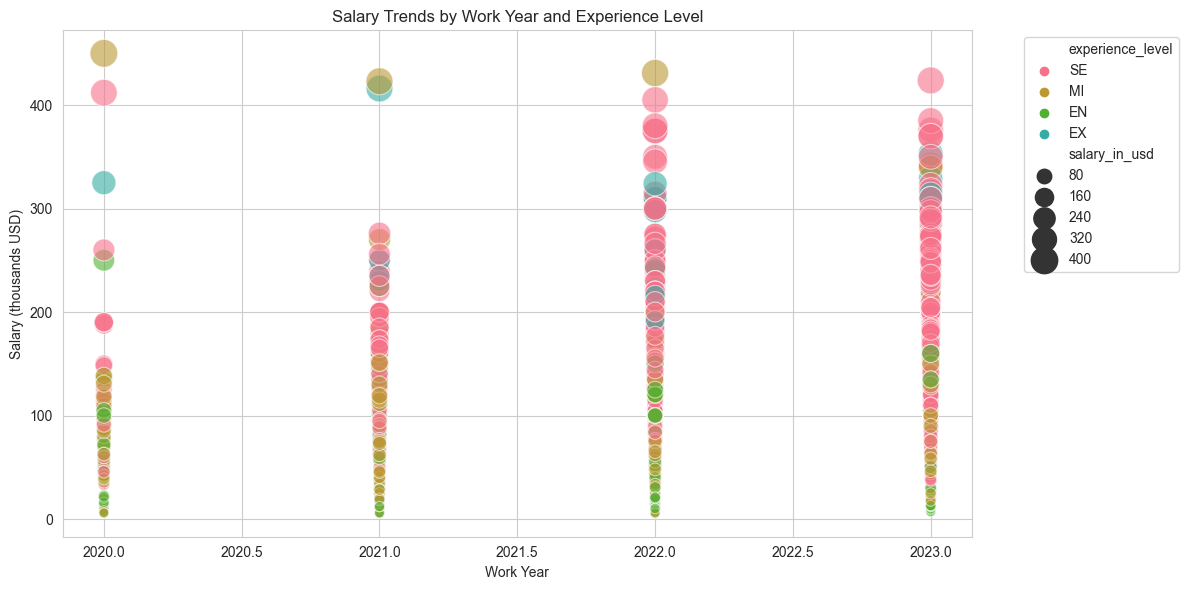

In [7]:
# 2.5 Salary by Work Year and Experience
plt.figure(figsize=(12, 6))
sns.scatterplot(data=processed_data, x='work_year', y='salary_in_usd', hue='experience_level', size='salary_in_usd',
                sizes=(50, 400), alpha=0.6)
plt.title('Salary Trends by Work Year and Experience Level')
plt.xlabel('Work Year')
plt.ylabel('Salary (thousands USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This scatter plot explores the intersection of time, experience, and salary. By using color and size to represent experience levels and salary magnitude, we can visualize how compensation evolves across different years and career stages.

## 3. Model Building and Evaluation

In [8]:
def build_model(data):
    # Prepare features and target
    feature_cols = ['work_year', 'experience_level_encoded', 'employment_type_encoded',
                   'job_title_encoded', 'employee_residence_encoded', 'remote_ratio_encoded',
                    'company_location_encoded', 'company_size_encoded']
    
    X = data[feature_cols]
    y = data['salary_in_usd']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train XGBoost model
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    return model, X_test, y_test, y_pred, X_train, feature_cols

In [9]:
# Build and evaluate model
model, X_test, y_test, y_pred, X_train, feature_cols = build_model(processed_data)

## 4. Error Analysis

Model Performance Metrics:
RMSE: 50.26k
MAE: 37.65k
MAPE: 0.37%
R2 Score: 0.360


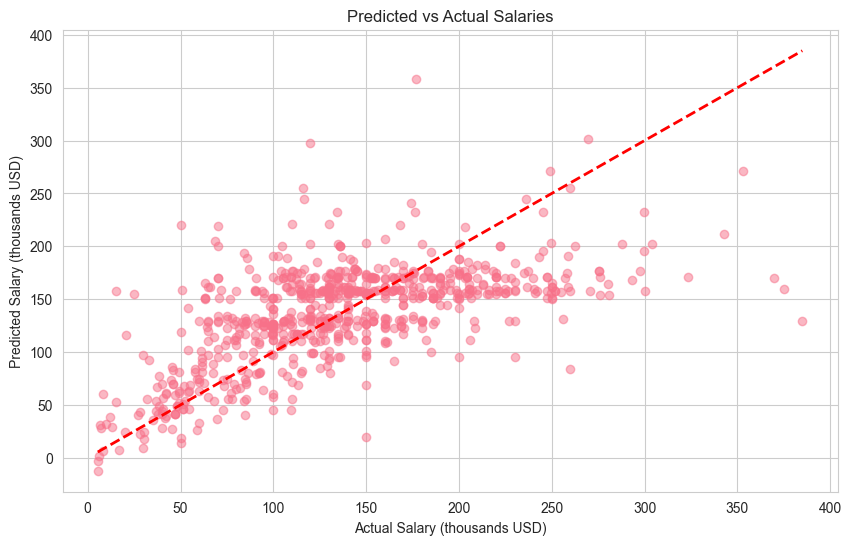

In [10]:
# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}k")
print(f"MAE: {mae:.2f}k")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.3f}")
    
# Create error analysis visualizations
# 4.1 Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary (thousands USD)')
plt.ylabel('Predicted Salary (thousands USD)')
plt.title('Predicted vs Actual Salaries')
plt.show()

The model performs worst on high-salary positions (>250k USD), showing significant underestimation for these cases, as seen in the Predicted vs Actual plot where points deviate more from the red line at higher salaries. It performs best on mid-range salaries (100k-150k USD), where predictions cluster more tightly around the ideal prediction line.
This pattern likely occurs because there are fewer samples of high-salary positions in the training data, and high-salary positions might have more unique combinations of features that make them harder to predict.

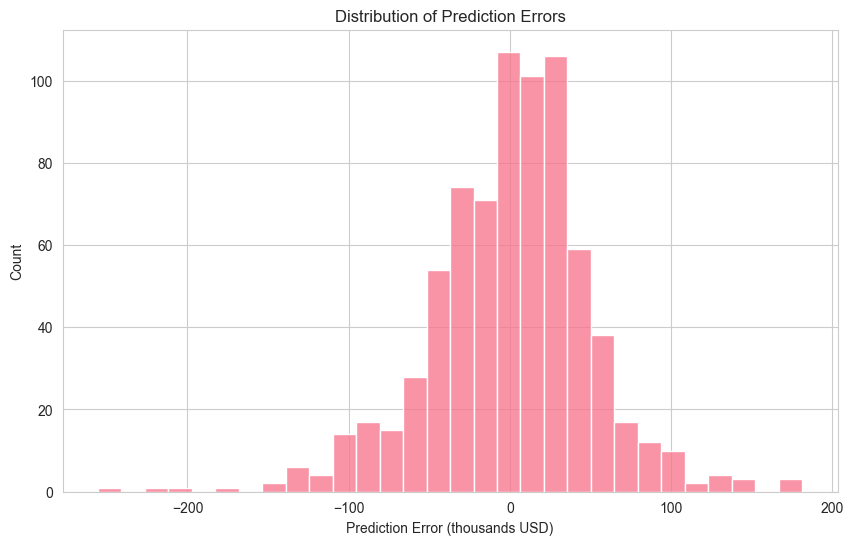

In [11]:
# 4.2 Error Distribution
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (thousands USD)')
plt.ylabel('Count')
plt.show()

The error distribution histogram shows a slight negative skew.
The model tends to underestimate salaries, particularly for high-paying positions.
This bias likely occurs because the model is trying to minimize overall error, and since there are more moderate-salary positions, it biases towards the mean. Also, extreme values are harder for the model to predict, leading to regression toward the mean.

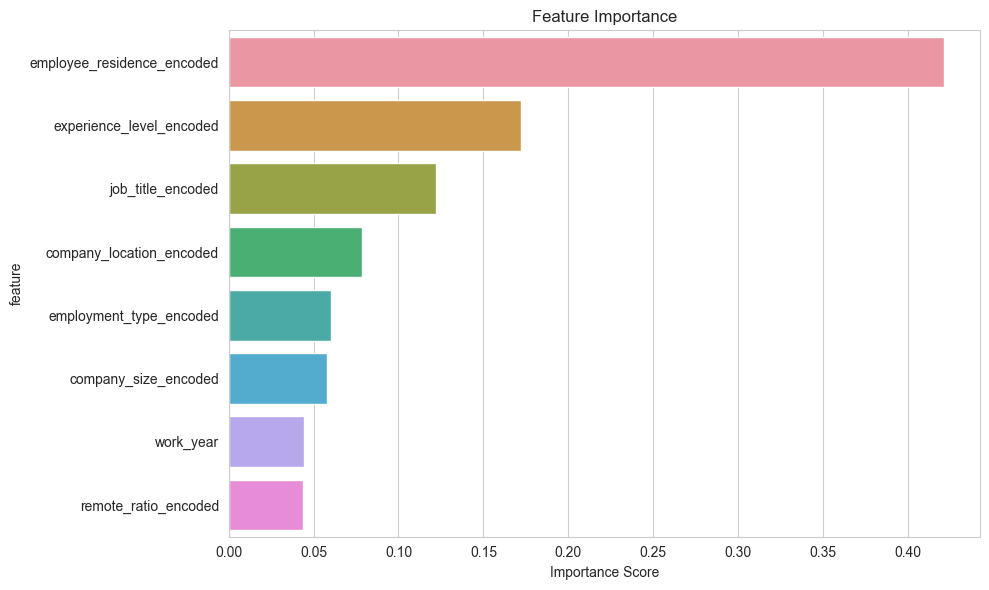

In [12]:
# 4.3 Feature Importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
   
plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Employee residence has the highest importance score (~0.40) which might be causing overfitting to location-specific patterns.
Work year and remote ratio have very low importance scores (<0.05), suggesting they might be adding noise rather than valuable information.
The job title feature's moderate importance might be problematic if there are too many unique titles, potentially causing sparsity issues.

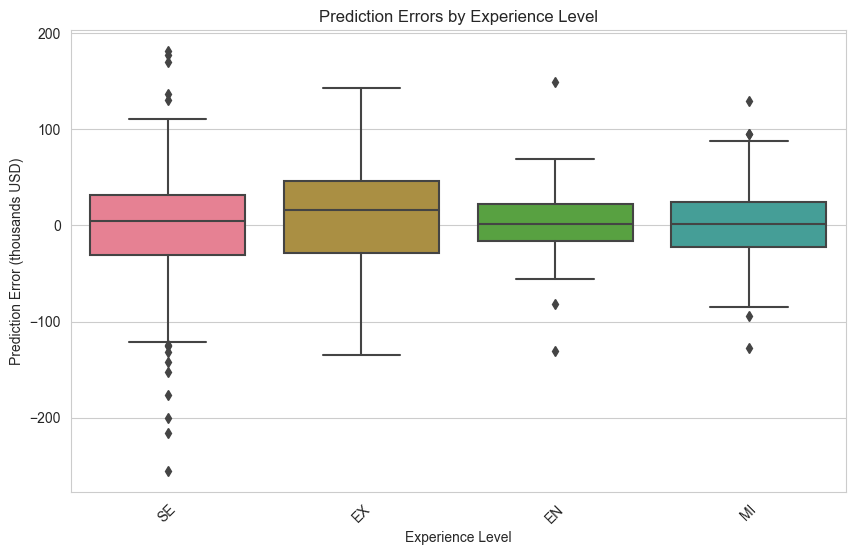

In [13]:
# 4.4 Error Analysis by Experience Level
test_data = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'error': errors,
    'experience_level': processed_data.loc[y_test.index, 'experience_level']
})
    
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_data, x='experience_level', y='error')
plt.title('Prediction Errors by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Prediction Error (thousands USD)')
plt.xticks(rotation=45)
plt.show()

Looking at the Error by Experience Level boxplot:
EX (Executive) level shows the widest error spread,
SE (Senior) level shows several significant outliers.
The model is most consistent (smallest box) for MI (Mid) level positions.
Common patterns in errors:
- Higher salaries tend to have larger absolute errors
- Executive and Senior positions show more variance in predictions
- The model struggles most with non-standard combinations of features (likely outliers in the dataset).